## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1:
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 4')

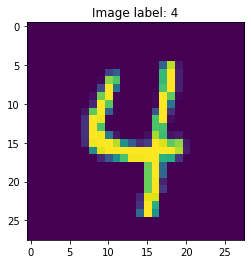

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

In [3]:
# help(train_mnist_data)

In [4]:
X_train = train_mnist_data.train_data
y_train = train_mnist_data.train_labels
X_test = test_mnist_data.test_data
y_test = test_mnist_data.test_labels

C:\Users\anike\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\anike\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\anike\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\anike\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
X_train.shape

torch.Size([60000, 28, 28])

<!-- * (N, C, H, W)
* N - количество картинок в батче
* C - количество каналов (для RGB - 3)
* W и H - ширина и высота картинки -->

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [6]:
from tqdm.auto import tqdm

In [7]:
# random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [8]:
X_train = X_train.float()
X_test = X_test.float()

# X_train = X_train.reshape([-1, 28 * 28])
# X_test = X_test.reshape([-1, 28 * 28])

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 100)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

In [10]:
# torch.cuda.is_available()
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)

In [11]:
# X_test = X_test.to(device)
# y_test = y_test.to(device)

In [12]:
model = Net()
# model = model.to(device) # your code here

Локальные тесты для проверки вашей модели доступны ниже:

In [13]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # x, y = x.to(device), y.to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model(x)

except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

In [14]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
batch_size = 100

In [15]:
test_accuracy_history = []
test_loss_history = []

for epoch in tqdm(range(100)):
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index + batch_size]

        X_batch = X_train[batch_indexes]#.to(device)
        y_batch = y_train[batch_indexes]#.to(device)

        # preds = model.forward(X_batch)
        preds = model(X_batch)


        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    test_preds = model(X_test)
    test_loss_history.append(loss(test_preds, y_test))

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
test_accuracy_history = [test_accuracy_history[i].detach().cpu().numpy() for i in range(len(test_accuracy_history))]
test_accuracy_history = np.array(test_accuracy_history)

In [17]:
test_loss_history = [test_loss_history[i].detach().cpu().numpy() for i in range(len(test_loss_history))]
test_loss_history = np.array(test_loss_history)

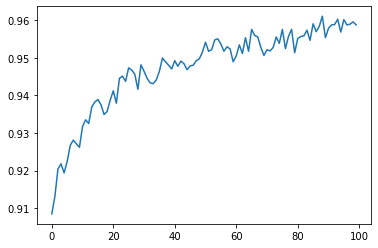

In [18]:
import matplotlib.pyplot as plt

plt.plot(test_accuracy_history)

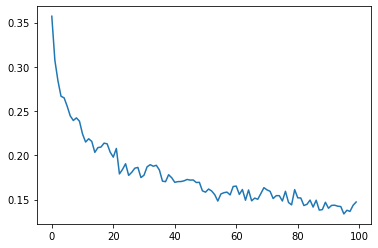

In [19]:
plt.plot(test_loss_history)

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [20]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        x = batch[0].reshape(-1, 784)
        # x = x.to(device)
        y_predicted = model.forward(x)
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
# real_labels = real_labels.to(device)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.96967


In [21]:
# unique, counts = np.unique(predicted_labels, return_counts=True)
# dict(zip(unique, counts))

In [22]:
# unique, counts = np.unique(real_labels, return_counts=True)
# dict(zip(unique, counts))

In [23]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        x = batch[0].reshape(-1, 784)
        # x = x.to(device)
        y_predicted = model(x)
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
# real_labels = real_labels.to(device)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9664


Проверка, что необходимые пороги пройдены:

In [24]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [25]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [26]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!